## Estimación de la homografía entre imágenes a partir de los matches 

A partir de la correspondencia entre puntos característicos, es posible determinar la transformación plana que relaciona las dos imágenes, pero no hay garantía que todas las correspondencias del matching sean buenas. Es necesario entonces estimar la homografía de forma robusta reconociendo cuáles son las correspondencias buenas (inliers) y descartando las malas (outliers).    

El cálculo robusto de la homografía se implementará mediante RANSAC.    

   
## Algoritmo RANSAC


El algoritmo **RANSAC** (RANdom SAmple Consensus) es un método robusto para estimar modelos a partir de datos contaminados con outliers o contaminados por ruido. El objetivo de RANSAC es encontrar el mejor modelo que se ajuste a los datos, incluso cuando una parte de los datos no se ajusta no sigue algún patrón general.

El algoritmo RANSAC se divide en las siguientes partes principales: selección de muestras aleatorias, estimación del modelo y evaluación del modelo.

1. En el primer paso, se seleccionan aleatoriamente un número mínimo de muestras del conjunto de datos. Luego, se estima un modelo utilizando estas muestras. 

2. En el segundo paso, se evalúa cuántos datos se ajustan al modelo dentro de un umbral predefinido de distancia o error. Los datos que se ajustan al modelo se consideran inliers, mientras que los que no se ajustan se consideran outliers. 

3. En el tercer paso, se repiten los dos pasos anteriores un número determinado de veces para encontrar el modelo que tenga la mayor cantidad de inliers.

Luego de que se repiten los puntos anteriores $N$ veces, se vuelve a calcular el modelo una última vez utilizando todos los inliers del mejor modelo encontrado en el bucle anterior. 

En este caso se utilizará el algoritmo de RANSAC para estimar una homografía, se tomarán conjuntos aleatorios de cuatro puntos (se sabe que una homografía queda determinada con cuatro puntos, sin haber tres alineados) y se calculará la homografía correspondiente. Luego se compara la distancia entre los puntos destino originales y los calculados a partir de la homografía encontrada con un umbral, siendo los puntos que están por debajo del umbral inliers y los demás outliers. Una vez se hicieron todas las iteraciones, se vuelve a calcular la homografía con todos los mejores inliers inliers y se devuelve esa $H$.

El libro recomendado habla de como tomar la cantidad de iteraciones $N$ al momento de utilizar el algorítmo, a continuación un comentario muy generales sobre lo que se recomienda:

El número de iteraciones en RANSAC está relacionado con la probabilidad de encontrar una estimación de homografía correcta. La fórmula para calcular el número de iteraciones recomendado depende de la probabilidad de que una muestra aleatoria sea inlier y de la probabilidad deseada de obtener una estimación correcta.

#### Implementar la estimación de una homografía usando RANSAC

Para calcular la homografía utilizando ransac, se utilizan las siguientes funciones auxiliares.

*  De la librería opencv, **findHomography**, la cual a partir de cuatro o más puntos y sus respectivos destinos, devuelve la matríz correspondiente a la homografía.

* Para calcular el destino de puntos de origen, también de la libereria opencv, se utiliza **perspectiveTransform**. A partir puntos de origen y una homografía $H$ devuelve el resultado de aplicar $H$ a los puntos de origen.


In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
import cv2 as cv

In [7]:
def estimar_homografia_con_ransac(puntos_ori, puntos_dst, iteraciones, umbral_distancia):
    '''
    Estima una homografia usando RANSAC

    Parameters
    ----------
    puntos_ori : array Nx2 de coordenadas de puntos
        Puntos origen.
    puntos_dst : array Nx2 de coordenadas de puntos
        Puntos destino.
    iteraciones : int
        Cantidad de repeticiones del muestreo y calculo de posibles homografias.
    umbral_distancia : double
        Umbral para evaluar la distancia entre un punto destino y su 
        correspondiente proyectado por la homografia en evaluacion.

    Returns
    -------
    H : array 3x3
        Homografia estimada.
    indices_inliers : array
        Lista de los indices que resultaron inliers de H.
    indices_outliers : array
        Lista de los indices que resultaron outliers de H.
    '''
    
    N = puntos_ori.shape[0]
    
    #Variables para almacenar el mejor modelo
    best_H = None
    best_inliers = None
    best_num_inliers = 0
    
    #Creo vector auxiliar para ver inliers
    indices = np.arange(0, puntos_dst.shape[0])
    
    #Creo un elemento de la forma (N, 1, 2) N Arrays de 1 fila - 2 columnas para usar la función de cv2 perspectiveTransform
    #Dentro del bucle
    puntos_ori_temp = puntos_ori.reshape(-1, 1, 2)
    puntos_ori_temp = puntos_ori_temp.astype(np.float32)


    #Iteración para repetir RANSAC
    for i in range(iteraciones):
        
        #Se selecciona aleatoriamente un subconjunto de puntos
        indices_aleatorios = np.random.choice(puntos_ori.shape[0], 4, replace=True)
        sub_puntos_ori = puntos_ori[indices_aleatorios]
        sub_puntos_dst = puntos_dst[indices_aleatorios]
        
        #Se calcula homografía con función auxiliar del entregable anterior
        H, _ = cv.findHomography(sub_puntos_ori, sub_puntos_dst)
        #H = H.astype(np.float32)
        
        #Creo un elemento de la forma (N, 1, 2) N Arrays de 1 fila - 2 columnas para usar la función de cv2 perspectiveTransform
        #puntos_ori_temp = puntos_ori.reshape(-1, 1, 2)
        destino_aux = cv.perspectiveTransform(puntos_ori_temp, H)
        destino_aux = destino_aux.reshape(-1, 2)

        # Calcular la distancia entre los puntos proyectados y los puntos destino
        distancias = np.linalg.norm(puntos_dst - destino_aux, axis = 1)
        
        # Contar los inliers dentro del umbral de distancia
        inliers = distancias < umbral_distancia
        inliers = indices[inliers == True]
        num_inliers = len(inliers)
        
        #Actualizar si es mejor
        if num_inliers > best_num_inliers:
            best_H = H
            best_inliers = inliers
            best_num_inliers = num_inliers

    #Debo volver a calcular teniendo en cuenta todos los mejores inliers    
    H, _ = cv.findHomography(puntos_ori[best_inliers], puntos_dst[best_inliers])

    destino_aux = cv.perspectiveTransform(puntos_ori_temp, H)
    destino_aux = destino_aux.reshape(-1, 2)

    distancias = np.linalg.norm(puntos_dst - destino_aux, axis = 1)

    #Devuelvo inliers y outliers de la Homografía final.
    inliers = distancias < umbral_distancia
    inliers = indices[inliers == True]
    num_inliers = len(inliers)

    indices_inliers = inliers

    #Indices de outliers - Del array con todos los índices elimino los índices de los inliers
    indices_outliers = np.delete(indices, indices_inliers)
        
    return H, indices_inliers, indices_outliers

### Para probar el funcionamiento del algorítmo se estima la homografía a partir de las correspondencias entre las imágenes "peppers_dark" y "peppers_rotada".

En la siguiente celda se cargan las imágenes proporcionadas, se crea el elemento _sift_ y se hace el matching utilizando _BFMatcher_.  Luego, se obtienen las coordenadas de los _keypoints_ para finalmente ponerlas todas las coordenadas en los vectores _puntos_ori_ y _puntos_dst_.

In [8]:
img1 = imread('imagenes/peppers_dark.png')
img2 = imread('imagenes/peppers_rotada.png')

#Inicializo el detector SIFT
sift = cv.SIFT_create()

#Se encuentran los keypoints y descriptores con SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

#BFMatcher con parámetros por defecto
bf = cv.BFMatcher(crossCheck = True)
matches = bf.match(des1, des2)
        
puntos_ori_aux = []
puntos_dst_aux = []
    
#Obtengo coordenadas de cada kp para train y su correspondiente en query
for m in matches:
    indice_train = m.trainIdx
    indice_query = m.queryIdx
    puntos_ori_aux.append(kp1[indice_query].pt)
    puntos_dst_aux.append(kp2[indice_train].pt)
    
aux = 0
for punto in puntos_ori_aux:
    if(aux == 0):
        puntos_ori = np.array([punto])
        aux = -1
    else:
        puntos_ori = np.vstack((puntos_ori, punto))

aux = 0
for punto in puntos_dst_aux:
    if(aux == 0):
        puntos_dst = np.array([punto])
        aux = -1
    else:
        puntos_dst = np.vstack((puntos_dst, punto))

In [9]:
print('puntos de origen:')
print(puntos_ori.shape)
print('')

print('puntos de destino:')
print(puntos_dst.shape)

puntos de origen:
(258, 2)

puntos de destino:
(258, 2)


Ahora se procede a aplicar el algorítmo de RANSAC para estimar la homografía presente en las imágene proporcionadas.

In [10]:
H, indices_inliers, indices_outliers = estimar_homografia_con_ransac(puntos_ori, puntos_dst, 900, 8)


print('Homografía estimada con RANSAC')
print(H)
print('')
print('indices inliers - array de tamaño:', indices_inliers.shape)
print(indices_inliers)
print('')
print('indices outliers - array de tamaño:', indices_outliers.shape)
print(indices_outliers)

Homografía estimada con RANSAC
[[ 9.02764088e-01 -4.25178615e-01  1.32816204e+02]
 [ 4.21011214e-01  9.03545862e-01 -8.34361146e+01]
 [-3.93853448e-06 -3.14031074e-06  1.00000000e+00]]

indices inliers - array de tamaño: (175,)
[  0   2   4   8  10  11  14  15  19  20  25  26  28  32  33  34  36  37
  39  40  41  45  46  47  48  49  50  51  52  53  54  55  56  58  59  60
  61  62  64  66  67  68  69  70  71  73  80  83  84  87  89  90  92  93
  94  96  97  98 100 101 102 103 104 105 106 107 108 109 110 111 112 114
 115 116 117 118 119 120 121 123 124 125 126 128 129 131 132 134 135 136
 137 140 141 143 144 145 147 148 149 150 151 152 153 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 173 174 175 179 180 181
 182 183 184 185 186 190 192 193 194 195 196 197 202 203 204 205 206 208
 209 211 212 214 215 216 218 219 220 221 222 224 225 226 227 228 229 230
 231 232 234 236 237 238 239 240 243 244 247 250 256]

indices outliers - array de tamaño: (83,)
[  1   3   5   6  

El parámetro _crossCheck_ se utiliza para mejorar la precisión de las coincidencias. Cuando se establece en _True_, la función realiza una verificación cruzada de las coincidencias. Esto significa que considera una coincidencia válida solo si el descriptor del punto en la primera imagen coincide con el descriptor del punto correspondiente en la segunda imagen, y viceversa.

Esto puede ayudar a eliminar coincidencias erróneas que podrían ocurrir debido a la similitud de los descriptores. Al activar esta opción, se obtienen coincidencias más confiables. 

A continuación se verifica si la homografía obtenida es correcta.

### Verificación

Primero se aplica la homografía estimada con RANSAC a la imagen original para ver si el resultado se parece a la imagen rotada.

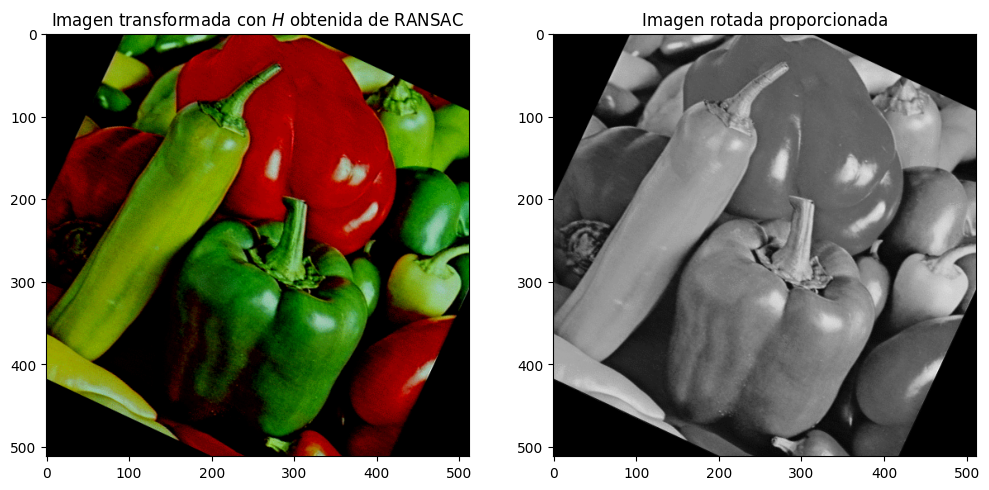

In [11]:
#Obtengo las dimensiones de la imagen original
height, width = img1.shape[:2]

#Aplica la transformación 
output_img = cv.warpPerspective(img1, H, (width, height))

#Plot
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.title('Imagen transformada con $H$ obtenida de RANSAC')
plt.imshow(output_img)
plt.subplot(1,2,2)
plt.title('Imagen rotada proporcionada')
plt.imshow(img2, cmap = 'gray')
plt.show()



En la imagen de la izquierda, se aprecia el resultado de aplicar la estimación de homografía utilizando el algoritmo RANSAC a la imagen base. En contraste, a la derecha se muestra la imagen que ya se encontraba previamente rotada (la imagen proporcionada en las carpetas de la tarea).

Este resultado permite verificar de manera efectiva el correcto funcionamiento del algoritmo RANSAC. Al aplicar la homografía estimada $H$ a la imagen base, se obtiene una imagen en la que se puede observar una clara correspondencia con la imagen originalmente rotada proporcionada.

Esto confirma que el algoritmo RANSAC ha logrado capturar de forma precisa la transformación proyectiva que ocurrió en la imagen original. 

A continuación se muestran los matches correspondiente a los puntos inliers y los outleirs.

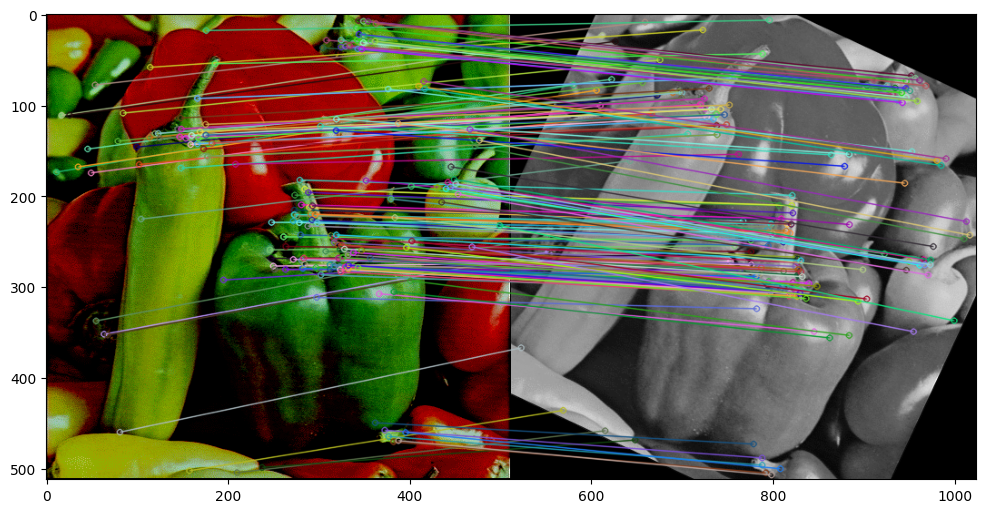

In [21]:
matches_evaluados = [matches[i] for i in indices_inliers]
img4 = cv.drawMatches(img1, kp1, img2, kp2, matches_evaluados, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (12,8))
plt.imshow(img4)
plt.show()

En esta parte se muestran todos los bueno matches cuyos indices fueron obtenidos anteriormente por la función **estimar_homografia_con_ransac**. A continuación también se mostrarán los outleirs.

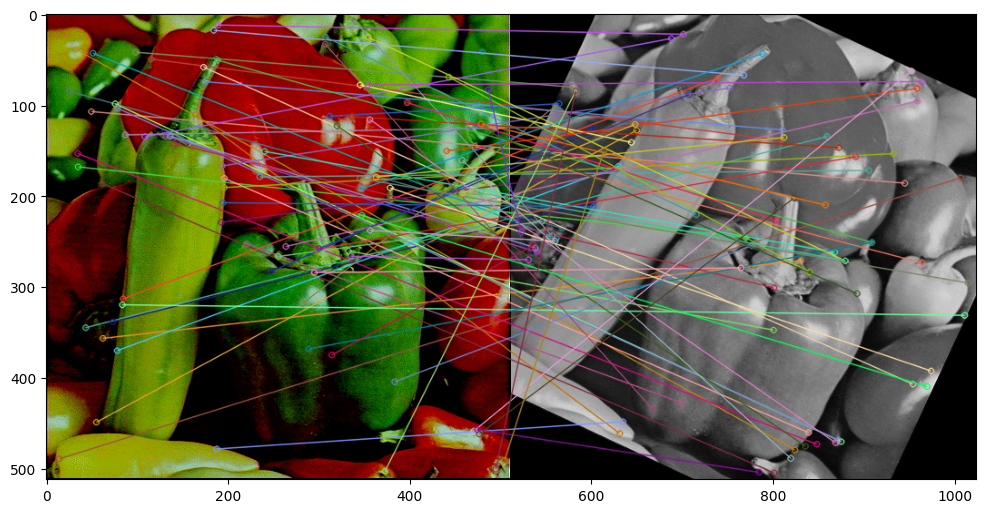

In [22]:
matches_evaluados = [matches[i] for i in indices_outliers]
img5 = cv.drawMatches(img1, kp1, img2, kp2, matches_evaluados, None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize = (12,8))
plt.imshow(img5)
plt.show()